# Good News
A service to find good news from your usual headlines :)

- Trained on data from https://www.kaggle.com/uciml/news-aggregator-dataset.
- Followed MSFT tutorial here: https://notebooks.azure.com/Microsoft/libraries/samples/html/Discover%20Sentiments%20in%20Tweets.ipynb
- Also followed NLTK tutorial here: http://www.nltk.org/howto/sentiment.html

In [33]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Data Import

In [7]:
data = pd.read_csv('uci-news-aggregator.csv', index_col='ID', \
                   engine='c', parse_dates=['TIMESTAMP'])
data.columns = ['title', 'url', 'publisher', 'category', 'story', 'hostname', 'timestamp']

data.head()

,title,url,publisher,category,story,hostname,timestamp
ID,,,,,,,
1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


The alphanumeric news ID and hostname aren't useful for our purposes, so we remove them:

In [27]:
data.drop(['story', 'hostname'], axis=1, inplace=True)

Let's reduce the data size by removing columns we don't need. The `category` column, for example, looks unchanging. First we define a function to identify unchanging columns.

In [28]:
def identify_unchanging_columns(df):
    ''' 
    Iterates through each column in a DataFrame. Returns a list of columns that hold only 1 value. 
    Note that missing values do not count as a "new" value:
    
    Ex:
    [1, 1, 1] is unchanging
    [1, None, 1] is unchanging
    [1, NaN, 1] is unchanging
    
    [1, 2, 1] is NOT unchanging
    '''
    
    unchanging = []
        
    for col_name in df.columns:
        if len(df[col_name].unique()) == 1:
            unchanging.append(col_name)
        
    return unchanging

In [29]:
# Test for identify_unchanging_columns
unchanging_data = {
    'first': ['the', 'quick', 'brown', 'fox'],
    'wrong1': ['wrong' for i in range(4)],
    'second': ['jumps', 'over', 'the', 'lazy'],
    'wrong2': ['dog' for j in range(4)],
    'missing': [1, 1, None, 1]
}

has_unchanging = pd.DataFrame(unchanging_data)

found_unchanging_cols = identify_unchanging_columns(has_unchanging)
expected_unchanging_cols = ['wrong1', 'wrong2']

assert found_unchanging_cols == expected_unchanging_cols

Now let's see if there are any unchanging columns:

In [30]:
unchanging = identify_unchanging_columns(data)
print(unchanging)

[]


Next, we deal with missing values. The title by far is most important, so we immediately drop any rows with a missing title.

In [38]:
print(data.shape)
data.dropna(subset=['title'], inplace=True)
print(data.shape)

(422419, 5)
(422419, 5)


Luckily, as we can see, there were no rows with missing titles.

Lastly, we check the data types of each row.

In [44]:
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms') # milliseconds from Unix epoch

type(data['timestamp'][1])

pandas._libs.tslib.Timestamp

## EDA

In [45]:
data.head()

,title,url,publisher,category,timestamp
ID,,,,,
1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,2014-03-10 16:52:50.698
2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,2014-03-10 16:52:51.207
3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,2014-03-10 16:52:51.550
4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,2014-03-10 16:52:51.793
5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,2014-03-10 16:52:52.027


Let's see how many articles are in each type of category: `b` for business, `t` for science and technology, `e` for entertainment, and `m` for health.

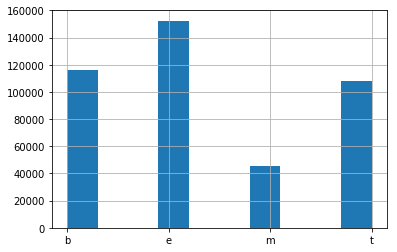

In [47]:
# Warning: Takes ~10 seconds to run
data['category'].hist();

We have a well-distributed mix of articles, so we will avoid too much bias towards any particular type of headline.

## Model Preparation

While a simple positive/negative/neutral classification might suffice, the ultimate goal of this algorithm is to show the most relevant news stories to the user. This consists of two components:
1. Sentiment (e.g. how positive is this article?), and
2. Relevance (e.g. how likely is the user to read this article?).

In order to rank these articles, we need an **unsupervised regressor model** which is also intelligent enough to consider user activity.